# Minimal example for PyMC3

## Setup

### Import libraries

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm

az.style.use("arviz-darkgrid")

In [2]:
print(pm.__version__)
print(az.__version__)

3.11.5
0.12.1


### Setup plotting

In [3]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [4]:
# fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [5]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [6]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

## Execute

### Define sample data

In [7]:
N_obs = 100

In [8]:
observations = np.random.randn(N_obs)

### Define model

In [9]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=observations)

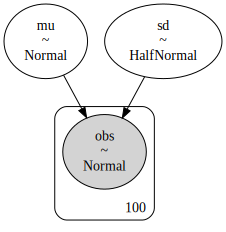

In [10]:
pm.model_to_graphviz(model)

### Fit model

In [11]:
with model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000, tune=500, cores=4, return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [12]:
[v.shape for k,v in posterior_predictive.items()]

[(4000, 100)]

In [13]:
[v.shape for k,v in prior.items()]

[(500,), (500,), (500, 100), (500,)]

### Organize output data

In [14]:
with model:
    data = az.from_pymc3(
        model=model,
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )

In [15]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

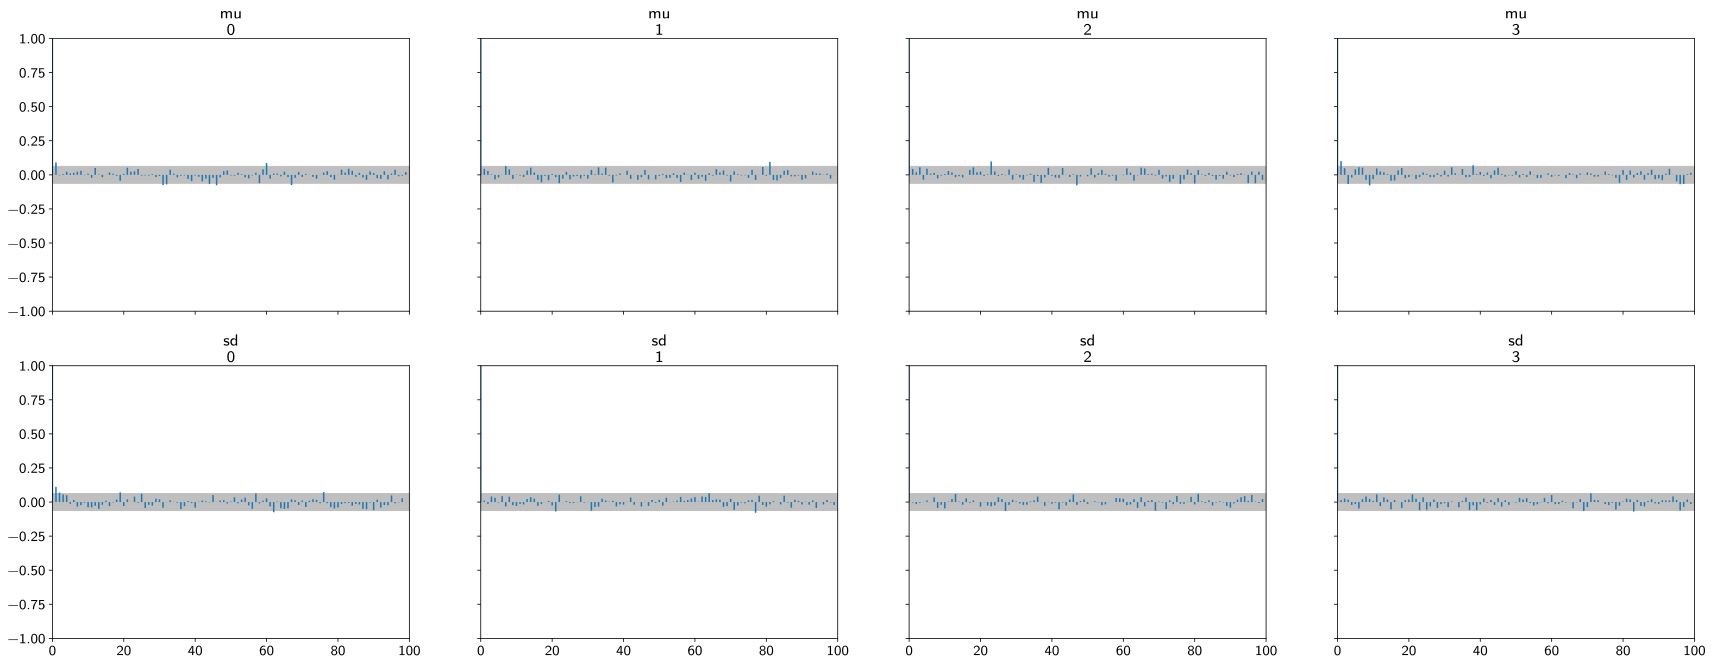

In [16]:
with model:
    az.plot_autocorr(trace, var_names=["mu", "sd"])

#### Plot prior and posterior predictive distributions

In [17]:
data.prior_predictive

<xarray.Dataset>
Dimensions:    (chain: 1, draw: 500, obs_dim_0: 100)
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * obs_dim_0  (obs_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_0) float64 1.011 1.001 ... 1.232 3.751
Attributes:
    created_at:                 2022-06-11T02:16:25.230504
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5

In [18]:
data.posterior_predictive

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, obs_dim_0: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_0  (obs_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_0) float64 0.03848 -2.107 ... 0.3643 1.162
Attributes:
    created_at:                 2022-06-11T02:16:25.227102
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5

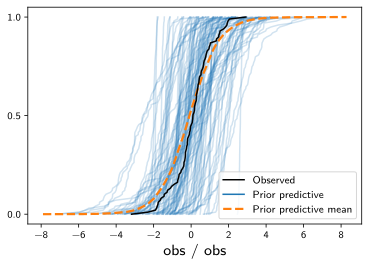

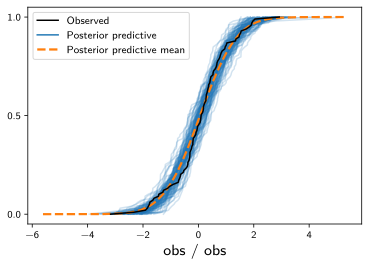

In [19]:
az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
)
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
);

In [20]:
print(data.prior_predictive.sizes["chain"])
data.prior_predictive.sizes["draw"]

1


500

In [21]:
print(data.posterior_predictive.sizes["chain"])
data.posterior_predictive.sizes["draw"]

4


1000

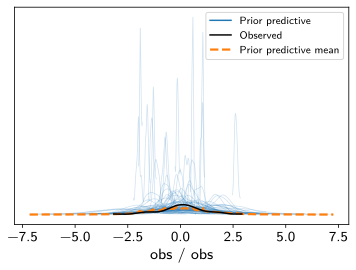

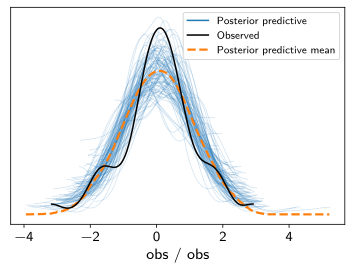

In [22]:
az.plot_ppc(
    data, 
    group="prior", 
    data_pairs={"obs": "obs"}, 
    num_pp_samples=100, 
    random_seed=7
)
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
);

#### Characterize posterior distribution

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

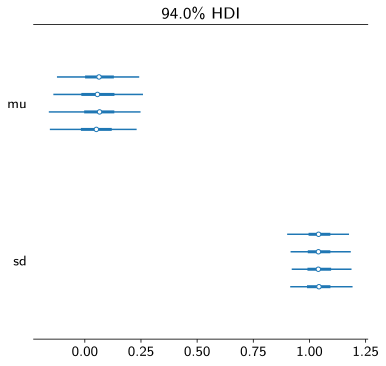

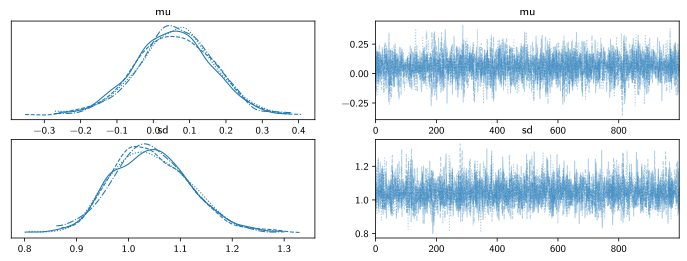

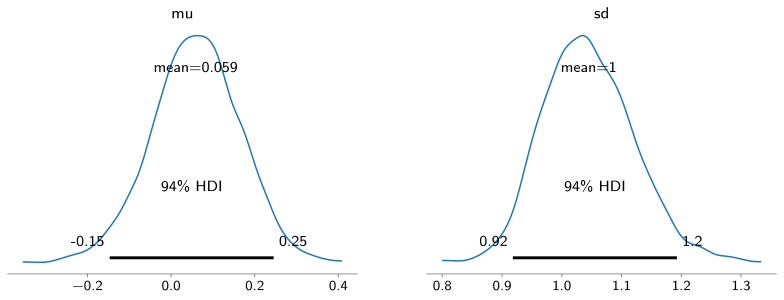

In [23]:
az.plot_forest(data)
az.plot_trace(data)
az.plot_posterior(data)